In [1]:
# AI Model: MFCC feature set, GMM classifier
# Training Data Used: Publicly available adult gulp dataset
# Total gulps in training dataset: ~1500
# Test file in this script: Publicly available adult gulp dataset


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from functions import static_feat_extract
import librosa
import IPython

import torch
import torch.nn as nn

In [2]:
audio_file_test = "C:/Users/ankur/OneDrive/Desktop/bib_project/dataset/signals/ns011a_3.npy"
audio_signal_test = {}
sr = 4000
audio_signal_test[audio_file_test.split('/')[-1][:8]] = np.load(audio_file_test)[:,0]

In [3]:
import IPython
s1 = np.load(audio_file_test)
IPython.display.Audio(data=s1[:,0], rate=sr)

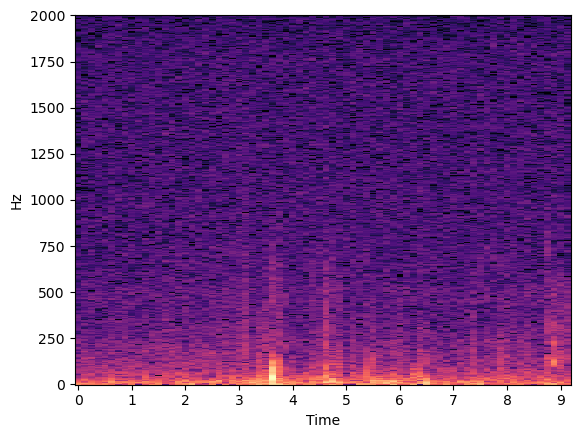

In [4]:
nfft = 1024
hop = 500
win_len = 1000
s1_spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(s1[:,0], n_fft=nfft, hop_length = hop, win_length = win_len)))
librosa.display.specshow(s1_spectrogram, sr=sr, hop_length=hop, x_axis = 'time', y_axis = 'linear')


In [5]:
# feature extraction
import pickle
stat = librosa.feature.mfcc(s1[:,0], sr = sr, n_mfcc = 20, n_mels = 40, n_fft = 512, hop_length = 20, win_length = 200)

# load pretrained models
with open('gmm_mfcc_static_gulp.pkl', 'rb') as f:
    gmm_gulp = pickle.load(f)
    
with open('gmm_mfcc_static_nongulp.pkl', 'rb') as f:
    gmm_nongulp2 = pickle.load(f)

# get the predictions
sc1 = gmm_gulp.score_samples(stat.T)
sc2 = gmm_nongulp2.score_samples(stat.T)
scr = sc1 - sc2

In [6]:
preds = []

for v in scr:
    if v < 0:
        preds.append(0)
    else:
        preds.append(1)
        
# plt.plot(preds)

In [7]:
# Define the window size for the moving average filter
window_size = 50

# Create a filter kernel with the desired weights
kernel = np.ones(window_size) / window_size

# Use the convolve function to apply the filter to the signal
filtered_signal = np.convolve(preds, kernel, mode='valid')

In [8]:
num_gulps = 0
signal = filtered_signal 
threshold = 0.40

# Loop through the signal and count the number of upward threshold crossings
for i in range(1, len(signal)):
    if signal[i-1] > threshold and signal[i] <= threshold:
        num_gulps += 1

print("Number of gulps:", num_gulps)

Number of gulps: 7


In [9]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

# create a neural network instance
model = NeuralNet(input_size=5, hidden_size=64, output_size=1)

model.load_state_dict(torch.load("C:/Users/ankur/OneDrive/Desktop/bib_project/dataset/model_weights.pth"))
model.eval()

# # [duration, num_gulps, gender, weight, age]
ip = torch.Tensor([10.96, num_gulps, 1.0, 5., 3.])
op = model(ip)

print(f"The total amount of milk consumed in ml: {op.item()}")
# Put the model in evaluation mode
# model1.eval()

The total amount of milk consumed in ml: 182.52081298828125
